# 11. Machine Learning Model and Evalution 2 - Scaling

#### This script trains a baseline and 'main' model on the scaled training data and evaluates them on the test set after scaling

### Imports

In [1]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.stats import reciprocal, uniform
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt

### Definitions

In [2]:
data_filename = 'data/MachineLearningData.csv'

baseline_model_filename = 'TrainedModels/Baseline.bin'
final_model_filename = 'TrainedModels/Final.bin'

svm_model_filename = 'TrainedModels/SVM.bin'

### Defining helper function

In [3]:
def plot_confusion_matrix(targets = [], predicted = [], labels = []):
    cm = metrics.confusion_matrix(targets, predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize confusion matrix
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.rcParams["figure.figsize"] =  [15, 9]
    plt.show(block=False)

### Load Dataframe

In [4]:
# Note: We call this df_train for memory issues
df_train = pd.read_csv(data_filename).dropna()
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,PostID,WordCount,SentenceCount,AvgWordLength,AvgSentenceLength,UniqueWordsPercentage,URLCount,ableWords,alWords,fulWords,...,fw_by,fw_these,fw_second,fw_do,fw_shall,fw_of,fw_most,fw_mine,fw_under,fw_even
0,277565.0,120,12,3.783333,10.000000,0.708333,0.000000,0.008333,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.013605,0.000000,0.0,0.0,0.006803
1,573553.0,246,13,4.130081,18.923077,0.617886,0.016260,0.000000,0.008130,0.000000,...,0.003774,0.000000,0.0,0.000000,0.0,0.018868,0.000000,0.0,0.0,0.000000
2,210974.0,67,7,3.567164,9.571429,0.791045,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.013699,0.000000,0.0,0.0,0.000000
3,424247.0,669,59,4.240658,11.338983,0.562033,0.000000,0.001495,0.010463,0.000000,...,0.001323,0.000000,0.0,0.001323,0.0,0.021164,0.001323,0.0,0.0,0.000000
4,294114.0,35,4,4.857143,8.750000,0.942857,0.000000,0.000000,0.028571,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.024390,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676308,501847.0,307,39,3.469055,7.871795,0.602606,0.000000,0.000000,0.000000,0.003257,...,0.000000,0.000000,0.0,0.000000,0.0,0.006042,0.003021,0.0,0.0,0.003021
676309,485774.0,49,5,3.591837,9.800000,0.857143,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.018182,0.0,0.000000,0.0,0.018182,0.000000,0.0,0.0,0.000000
676310,203910.0,110,11,4.081818,10.000000,0.809091,0.000000,0.000000,0.009091,0.009091,...,0.000000,0.007634,0.0,0.007634,0.0,0.015267,0.000000,0.0,0.0,0.000000
676311,169603.0,280,17,5.000000,16.470588,0.696429,0.007143,0.007143,0.010714,0.000000,...,0.000000,0.000000,0.0,0.003247,0.0,0.025974,0.000000,0.0,0.0,0.000000


### Filter and split into train and test set

In [5]:
df_test = df_train[ df_train['TrainTest'] == 'test' ]

# df_male = df_test[ df_test['Gender'] == 'male' ][:5000]
# df_female = df_test[ df_test['Gender'] == 'female' ][:5000]
# df_test = df_male.append(df_female, ignore_index=True)

y_test = df_test['Gender']
df_test = df_test.drop(['TrainTest', 'Gender', 'PostID'], axis=1)

df_train = df_train[ df_train['TrainTest'] == 'train' ]

# df_male = df_train[ df_train['Gender'] == 'male' ][:5000]
# df_female = df_train[ df_train['Gender'] == 'female' ][:5000]
# df_train = df_male.append(df_female, ignore_index=True)

y_train = df_train['Gender']
df_train = df_train.drop(['TrainTest', 'Gender', 'PostID'], axis=1)

### Check how many train and test items there are

In [6]:
print('Number of TOTAL training examples: {0}'.format(df_train.shape[0]))
print('Number of MALE training examples: {0}'.format(np.sum(y_train == 'male' )))
print('Number of FEMALE training examples: {0}'.format(np.sum(y_train == 'female')))
print()
print('Number of TOTAL testing examples: {0}'.format(df_test.shape[0]))
print('Number of MALE testing examples: {0}'.format(np.sum(y_test == 'male')))
print('Number of FEMALE testing examples: {0}'.format(np.sum(y_test == 'female')))

Number of TOTAL training examples: 537215
Number of MALE training examples: 268572
Number of FEMALE training examples: 268643

Number of TOTAL testing examples: 139098
Number of MALE testing examples: 74300
Number of FEMALE testing examples: 64798


### Fit the scaler on the train set and transform the train set to scaled

In [7]:
scaler = StandardScaler(copy=False, with_mean=True, with_std=True)

df_train = pd.DataFrame(scaler.fit_transform(df_train.values))

df_train

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
0,-0.193335,-0.130153,-0.030846,-0.205973,-0.076758,-0.256883,1.519484,-0.406924,-0.158484,-0.141943,...,-0.270169,-0.171567,-0.109221,-0.446176,-0.074722,0.049277,-0.208572,-0.075663,-0.085034,1.902201
1,-0.301589,-0.254424,-0.047844,-0.228945,0.424658,-0.256883,-0.221299,-0.406924,-0.158484,-0.141943,...,-0.270169,-0.171567,-0.109221,-0.446176,-0.074722,0.055389,-0.208572,-0.075663,-0.085034,-0.275759
2,0.928015,1.037994,0.005114,-0.134204,-0.963664,-0.256883,0.090949,0.421532,-0.158484,-0.141943,...,-0.094122,-0.171567,-0.109221,-0.293930,-0.074722,0.545057,0.296444,-0.075663,-0.085034,-0.275759
3,-0.366950,-0.328987,0.053589,-0.272973,1.344978,-0.256883,-0.221299,1.855267,-0.158484,-0.141943,...,-0.270169,-0.171567,-0.109221,-0.446176,-0.074722,0.756670,-0.208572,-0.075663,-0.085034,-0.275759
4,0.439850,0.317222,0.019655,0.026293,-0.564320,-0.256883,-0.221299,0.145472,-0.158484,-0.141943,...,0.006529,1.116647,-0.109221,-0.206888,-0.074722,0.656891,-0.208572,-0.075663,-0.085034,0.389854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537210,0.188619,0.540910,-0.055558,-0.320045,-0.717701,-0.256883,-0.221299,-0.406924,0.429406,-0.141943,...,-0.270169,-0.171567,-0.109221,-0.446176,-0.074722,-0.446802,0.944878,-0.075663,-0.085034,0.691492
537211,-0.338355,-0.304133,-0.045903,-0.216693,0.825359,-0.256883,-0.221299,-0.406924,-0.158484,-0.141943,...,-0.270169,5.461440,-0.109221,-0.446176,-0.074722,0.349449,-0.208572,-0.075663,-0.085034,-0.275759
537212,-0.213760,-0.155008,-0.007376,-0.205973,0.534057,-0.256883,-0.221299,0.312864,1.482262,2.641672,...,-0.270169,2.193436,-0.109221,0.432432,-0.074722,0.158273,-0.208572,-0.075663,-0.085034,-0.275759
537213,0.133470,-0.005882,0.064822,0.140850,-0.148927,-0.172357,1.270801,0.441398,-0.158484,-0.141943,...,-0.270169,-0.171567,-0.109221,-0.072482,-0.074722,0.860553,-0.208572,-0.075663,-0.085034,-0.275759


### Transform the test set with the scaler

In [8]:
df_test = pd.DataFrame(scaler.transform(df_test.values))

df_test

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,164
0,0.064024,-0.105299,-0.003581,0.272303,-0.625069,-0.064467,-0.221299,0.236789,-0.158484,-0.141943,...,0.232064,-0.171567,-0.109221,-0.446176,-0.074722,0.394452,-0.208572,-0.075663,-0.085034,-0.275759
1,-0.389418,-0.353841,0.002572,-0.313173,0.933613,0.236182,-0.221299,-0.406924,-0.158484,-0.141943,...,-0.270169,-0.171567,-0.109221,-0.446176,-0.074722,-0.843127,-0.208572,-0.075663,-0.085034,-0.275759
2,-0.034017,-0.080445,-0.016589,0.016084,-0.604906,-0.256883,-0.221299,-0.007042,-0.158484,-0.141943,...,-0.270169,-0.171567,-0.109221,-0.446176,-0.074722,0.031429,-0.208572,-0.075663,-0.085034,1.147175
3,0.736017,0.491202,0.002464,0.090999,-1.376622,-0.256883,-0.221299,-0.269225,0.155398,0.390575,...,0.152345,-0.171567,-0.109221,-0.263481,-0.074722,0.406239,-0.208572,-0.075663,-0.085034,-0.275759
4,-0.279121,-0.353841,-0.008769,0.651625,0.681020,-0.256883,-0.221299,-0.406924,-0.158484,-0.141943,...,-0.270169,-0.171567,-0.109221,-0.446176,-0.074722,-0.097767,-0.208572,-0.075663,-0.085034,-0.275759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139093,0.448020,0.292368,0.017716,0.060178,-0.822896,-0.256883,-0.221299,-0.042054,-0.158484,-0.141943,...,0.003120,-0.171567,1.159846,-0.446176,-0.074722,1.177151,-0.208572,-0.075663,-0.085034,-0.275759
139094,-0.420056,-0.403550,0.091032,-0.259573,1.017811,1.057957,-0.221299,8.390488,-0.158484,-0.141943,...,-0.270169,-0.171567,-0.109221,-0.446176,-0.074722,5.119753,-0.208572,-0.075663,-0.085034,-0.275759
139095,-0.395546,-0.378695,0.001168,-0.179173,0.825359,0.306620,-0.221299,-0.406924,-0.158484,-0.141943,...,-0.270169,-0.171567,-0.109221,-0.446176,-0.074722,-0.843127,-0.208572,-0.075663,-0.085034,-0.275759
139096,0.184534,0.342076,-0.032113,-0.214618,-0.673870,-0.256883,-0.221299,0.371863,0.433261,0.861984,...,0.117854,-0.171567,-0.109221,-0.110614,-0.074722,-0.269439,-0.208572,-0.075663,-0.085034,0.657652


### Train the baseline

In [9]:
# Tune hyperparmeters by sklearn's random search
param_distributions =  {"C": uniform(0.001, 10)}

lr = LogisticRegression(penalty='l2', tol=0.0001, C=1.0,
                        fit_intercept=True, class_weight=None,
                        random_state=42, solver='newton-cg', max_iter=100, multi_class='auto',
                        verbose=1, warm_start=False, n_jobs=-1, l1_ratio=None)

# random search trough the hyperparameters
clf_search_cv = RandomizedSearchCV(lr,
                                    param_distributions,
                                    iid=False,
                                    n_iter=20,
                                    n_jobs=2,
                                    pre_dispatch='2*n_jobs',
                                    cv=5,
                                    refit=True,
                                    verbose=False, 
                                    random_state=42,
                                    return_train_score=False
                                   )

clf_search_cv.fit(df_train.iloc[:10000], y_train[:10000])

lr = clf_search_cv.best_estimator_
lr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished


LogisticRegression(C=1.561186404424365, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=1,
                   warm_start=False)

In [10]:
# Train it
lr.fit(df_train, y_train)
dump(lr, baseline_model_filename)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  9.6min finished


['TrainedModels/Baseline.bin']

### Evaluate the baseline

              precision    recall  f1-score   support

      female       0.58      0.57      0.57     64798
        male       0.63      0.63      0.63     74300

    accuracy                           0.60    139098
   macro avg       0.60      0.60      0.60    139098
weighted avg       0.60      0.60      0.60    139098



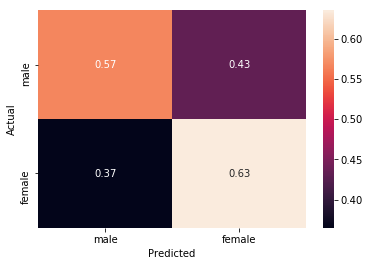

[[36734 28064]
 [27123 47177]]


In [11]:
lr = load(baseline_model_filename)
predictions = lr.predict(df_test)
print(metrics.classification_report(y_test, predictions))
plot_confusion_matrix(targets=y_test, predicted=predictions, labels=['male', 'female'])
print(metrics.confusion_matrix(y_test, predictions))

### Train the main model

In [12]:
# Tune hyperparmeters by sklearn's random search
param_distributions =  {'learning_rate_init': uniform(0.0001, 0.1),
                       'alpha': uniform(0.00001, 0.1)}

mlp = MLPClassifier (hidden_layer_sizes=(df_train.shape[1]+100, ),
                     activation='relu',
                     solver='adam', alpha=0.0001, batch_size=10000,
                     learning_rate='constant', learning_rate_init=0.001,
                     max_iter=100, shuffle=True, random_state=42,
                     tol=0.0001, verbose=False, warm_start=False, momentum=0.8,
                     early_stopping=True, validation_fraction=0.2,
                     beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)
# random search trough the hyperparameters
clf_search_cv = RandomizedSearchCV(mlp,
                                    param_distributions,
                                    iid=False,
                                    n_iter=30,
                                    n_jobs=-1,
                                    pre_dispatch='2*n_jobs',
                                    cv=3,
                                    refit=True,
                                    verbose=True, 
                                    random_state=42,
                                    return_train_score=False
                                   )

clf_search_cv.fit(df_train.iloc[:1000],
                  y_train[:1000])

mlp = clf_search_cv.best_estimator_
mlp

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   42.1s finished
/home/danielcauchi/miniconda3/envs/nlp/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:350: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "


MLPClassifier(activation='relu', alpha=0.043204501864211584, batch_size=10000,
              beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(265,), learning_rate='constant',
              learning_rate_init=0.029222914019804192, max_iter=100,
              momentum=0.8, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.2, verbose=False,
              warm_start=False)

In [13]:
# Train it
mlp.max_iter=300
mlp.n_iter_no_change=30
mlp.batch_size=100000
mlp.verbose = True
mlp.fit(df_train, y_train)
dump(mlp, final_model_filename)

Iteration 1, loss = inf
Validation score: 0.494532
Iteration 2, loss = 0.71295066
Validation score: 0.580457
Iteration 3, loss = 0.68549491
Validation score: 0.603101
Iteration 4, loss = inf
Validation score: 0.614056
Iteration 5, loss = 0.65852487
Validation score: 0.613590
Iteration 6, loss = 0.65332120
Validation score: 0.616801
Iteration 7, loss = inf
Validation score: 0.618430
Iteration 8, loss = 0.64759516
Validation score: 0.618607
Iteration 9, loss = 0.64581653
Validation score: 0.620729
Iteration 10, loss = 0.64393314
Validation score: 0.620133
Iteration 11, loss = 0.64325372
Validation score: 0.620161
Iteration 12, loss = 0.64227336
Validation score: 0.623037
Iteration 13, loss = 0.63977132
Validation score: 0.623894
Iteration 14, loss = 0.64005045
Validation score: 0.624238
Iteration 15, loss = 0.63772428
Validation score: 0.624396
Iteration 16, loss = 0.63817028
Validation score: 0.621343
Iteration 17, loss = 0.63636938
Validation score: 0.620757
Iteration 18, loss = 0.6360

['TrainedModels/Final.bin']

### Evaluate the Final

              precision    recall  f1-score   support

      female       0.56      0.57      0.57     64798
        male       0.62      0.61      0.62     74300

    accuracy                           0.59    139098
   macro avg       0.59      0.59      0.59    139098
weighted avg       0.59      0.59      0.59    139098



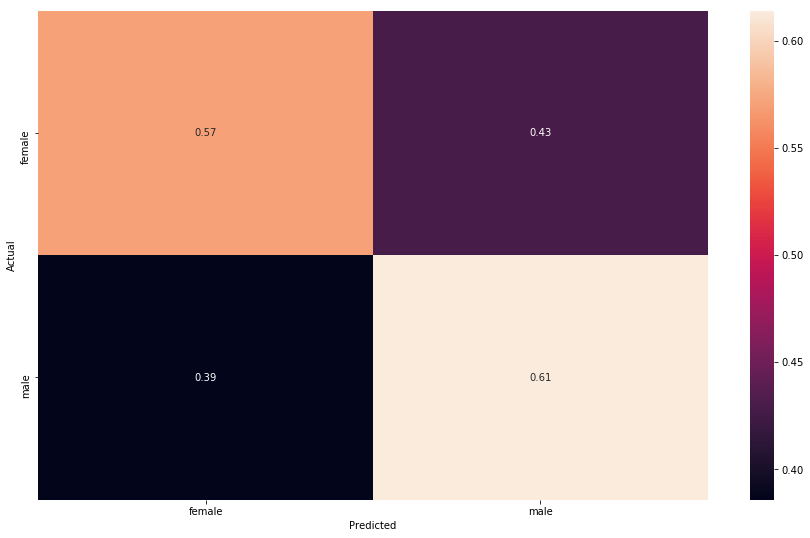

[[37005 27793]
 [28665 45635]]


In [14]:
mlp = load(final_model_filename)
predictions = mlp.predict(df_test)
print(metrics.classification_report(y_test, predictions))
plot_confusion_matrix(targets=y_test, predicted=predictions, labels=np.unique(y_test))
print(metrics.confusion_matrix(y_test, predictions))

### Train another model

In [15]:
# Tune hyperparmeters by sklearn's random search
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}

svm = SVC('rbf')

# random search trough the hyperparameters
clf_search_cv = RandomizedSearchCV(svm,
                                    param_distributions,
                                    iid=False,
                                    n_iter=30,
                                    n_jobs=-1,
                                    pre_dispatch='2*n_jobs',
                                    cv=3,
                                    refit=True,
                                    verbose=True, 
                                    random_state=42,
                                    return_train_score=False
                                   )

clf_search_cv.fit(df_train.iloc[:1000],
                  y_train[:1000])

svm = clf_search_cv.best_estimator_
svm

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   34.8s finished


SVC(C=1.884925020519195, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.002465844721448737,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [16]:
# Train it
svm.max_iter=1000
svm.verbose = True
svm.fit(df_train, y_train)
dump(svm, svm_model_filename)

[LibSVM]

/home/danielcauchi/miniconda3/envs/nlp/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


['TrainedModels/SVM.bin']

### Evaluate the other

              precision    recall  f1-score   support

      female       0.47      0.13      0.21     64798
        male       0.53      0.87      0.66     74300

    accuracy                           0.53    139098
   macro avg       0.50      0.50      0.43    139098
weighted avg       0.50      0.53      0.45    139098



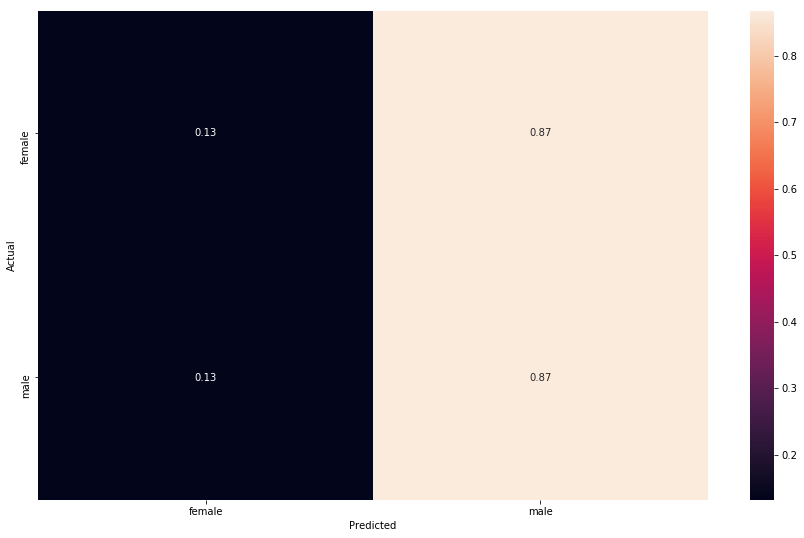

[[ 8639 56159]
 [ 9823 64477]]


In [17]:
svm = load(svm_model_filename)
predictions = svm.predict(df_test)
print(metrics.classification_report(y_test, predictions))
plot_confusion_matrix(targets=y_test, predicted=predictions, labels=np.unique(y_test))
print(metrics.confusion_matrix(y_test, predictions))